## Pseudocode Random-GL
Set random seed  
Create a list with the number of data points per client  
Create a variable for initial weights  
Create a variable for the maximum number of rounds  
Create an empty list for weighted average loss for each round  
Create an empty list for weighted average accuracy for each round  
Create a variable 'n' with a value of 0  
Create a list of clients  

For each round 'i' up to the maximum number of rounds:
- Randomize list of clients with the condition of that the last client from the previous client list not being equal to the first client of the current list
- For each client of list of clients:
    - If 'n' is equal to 0:
        - Train the first model
        - Save the model name for the next iteration
        - Set 'n' to 1
    - If 'n' is not equal to 0:
        - Save the weights of the previous iteration model
        - Assign the initial weights to the model for the new iteration
        - Train the new iteration model
        - Save the weights of the new iteration model
        - Save the weights in a list
        - Save the model name for the new iteration
        - Calculate the lengths of the previous and new iterations and store them in a list
        - Calculate weighted weights based on the lengths
        - Assign the weighted weights to the model
        - Save the model name for the next iteration
- Save the average loss for each round
- Save the average accuracy for each round

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
np.random.seed(0)
import random as rn
rn.seed(0)
import matplotlib.pylab as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
tf.random.set_seed(0)

2023-08-15 19:02:34.130084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 19:02:34.314106: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
os.getcwd()

'/srv'

In [3]:
# Loading processed and curated dataset:
dfHeart = pd.read_csv("/srv/heart_ConditionalMeanImputation.csv")
dfHeart

,Sex_F,Sex_M,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_N,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,40,140.0,289.0,0,172,0.0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,49,160.0,180.0,0,156,1.0,1
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,37,130.0,283.0,0,98,0.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,48,138.0,214.0,0,108,1.5,1
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,54,150.0,195.0,0,122,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,45,110.0,264.0,0,132,1.2,1
914,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,68,144.0,193.0,1,141,3.4,1
915,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,57,130.0,131.0,0,115,1.2,1
916,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,57,130.0,236.0,0,174,0.0,1


In [4]:
# X_clients = 9 # number of clients
# data_dict = {}

# for i in range(X_clients):
#   portion = 1/(X_clients)*len(dfHeart)
#   X = dfHeart.loc[i*portion:(i+1)*portion,:].drop(['HeartDisease'], axis=1)
#   y = dfHeart.loc[i*portion:(i+1)*portion,:]['HeartDisease']
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
#   client_data = {
#       'X_train': X_train,
#       'X_test': X_test,
#       'y_train': y_train,
#       'y_test': y_test
#   }
#   data_dict[f'client_{i+1}'] = client_data

In [5]:
dfHeart["Name"]="name"
# Estimated (from raw data) slices for each hospital
dfHeart.loc[0:293,"Name"] = "hung" # Hungarian Institute of Cardiology, Budapest
# Author: Andras Janosi, M.D.
dfHeart.loc[293:477,"Name"] = "swit" # University Hospital (Zurich and Basel) Switzerland
# Author: William Steinbrunn, M.D. and Matthias Pfisterer, M.D respectively.
dfHeart.loc[477:615,"Name"] = "long" # V.A. Medical Center, Long Beach
# Author: Robert Detrano, M.D., Ph.D.
dfHeart.loc[615:766,"Name"] = "stat" # Statlog dataset (confidential source)
# Author: "King RD. Department of Statistics and Modelling Science, University of Strathclyde, Glasgow"
dfHeart.loc[766:918,"Name"] = "clev" # Cleveland Clinic Foundation
# Author: Robert Detrano, M.D., Ph.D.

In [6]:
# Each group is divided into train and test groups and scaled
# Creation of data_dict dictionary
data_dict = {}
groups = dfHeart.groupby('Name')

for name, group in groups:
    X = group.drop(['HeartDisease', 'Name'], axis=1)
    y = group['HeartDisease']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    # Judith: escalamos los datos
    X_train = X_train.values
    X_test = X_test.values
    scaler = MinMaxScaler()
    scaler = scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    # Filling data_dict dictionary
    data_dict[name] = {
      'X_train': X_train,
      'X_test': X_test,
      'y_train': y_train,
      'y_test': y_test
  }

In [7]:
data_dict["long"]['X_train']

array([[0.        , 1.        , 0.        , ..., 0.        , 0.51351351,
        0.09756098],
       [0.        , 1.        , 0.        , ..., 0.        , 0.0990991 ,
        0.02439024],
       [0.        , 1.        , 0.        , ..., 0.        , 0.27927928,
        0.02439024],
       ...,
       [1.        , 0.        , 0.        , ..., 1.        , 0.45945946,
        0.02439024],
       [0.        , 1.        , 0.        , ..., 1.        , 0.3963964 ,
        0.26829268],
       [0.        , 1.        , 0.        , ..., 0.        , 0.72972973,
        0.02439024]])

In [8]:
data_dict.keys()

dict_keys(['clev', 'hung', 'long', 'stat', 'swit'])

In [9]:
#Creating neural network architecture
shape = data_dict[list(data_dict.keys())[0]]['X_train'].shape[1]
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=256, input_shape=(shape,), activation="relu", kernel_regularizer=regularizers.l1_l2(0.01)))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=128, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=32, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=1, activation="sigmoid"))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss="binary_crossentropy", 
                metrics=["accuracy", "AUC"])

2023-08-15 19:02:36.893834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 19:02:36.900270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 19:02:36.902925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 19:02:36.906516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

In [10]:
def ave_weights(n_i,listOfWeights):
    """
    Aggregation function

   :param list n_i: Number of samples for each client
   :param list listOfWeights: Weights for each client
   :return: Final weighted average for global model
    """
    N = sum(n_i) # total number of samples of all clients
    # initial weights of global model, set to zero
    ave_weights = listOfWeights[0]
    ave_weights = [i * 0 for i in ave_weights]
    # loop whose range is number of clients
    for j in range(len(n_i)):
        # receive weights from clients
        rec_weight = listOfWeights[j]
        # multiply the client weights by number of local data samples in client local data
        rec_weight =  [i * n_i[j] for i in rec_weight]
        # divide the weights by total number of samples of all clients
        rec_weight =  [i / N for i in rec_weight]
        # sum the weights of new client with the prior
        ave_weights = [x + y for x, y in zip(ave_weights,rec_weight)]
    return ave_weights

In [11]:
def weighted_mean(n_i, metric_list):
    """
    Calculate the weighted mean of an evaluation metric.

    :param list n_i: Number of samples for each client
    :param list metric_list: List of evaluation metric values for each client
    :return: Weighted mean of the evaluation metric
    """
    total_samples = sum(n_i)  # Total number of samples of all clients
    weighted_metric_sum = 0.0

    for j in range(len(n_i)):
        weighted_metric_sum += metric_list[j] * n_i[j]

    weighted_mean = weighted_metric_sum / total_samples
    return weighted_mean

-  Select a maximum number of rounds, leaving a validation set for each dataset.
-  Analyze the error/accuracy of the resulting model for each round in the validation of each dataset.
-  Calculate the weighted average of the error/accuracy for each round. In other words, for round i, we will have different error and accuracy values for each dataset. You can aggregate them (weighted based on the number of data points) and obtain the weighted average of the error and/or accuracy.

In [12]:
#Set random seed
rn.seed(42)

# List with number of samples for each client
n_i = [len(data_dict[name]['X_train']) for name in data_dict.keys()]

# Get initial weights from created model before loop
initial_weights = model.get_weights()

# Maximum number of rounds n_times
n_times = 300

acc_val_round = [] # accuracy validation of a round
loss_val_round = [] # loss validation of a round

n = 0 # Variable to enter with the first client at the first round

# Initial parameters previous random client list generation
my_list = list(data_dict.keys())

# Initial weights previous rounds, it will be updated for each client on each round
saveModels = [model.get_weights()]*len(my_list)

# Create a tuple, to associate "my_list" and "saveModels" positions, even when shuffling
client_data_list = [(my_list[i], saveModels[i]) for i in range(len(my_list))]

# Rounds of the randomized gossip learning
for i in range(1,n_times+1):

    # Each round of the randomized gossip learning      
    for name in [client_data[0] for client_data in client_data_list]:
        if n == 0:
            # Train client:
            history = model.fit(data_dict[name]['X_train'],data_dict[name]['y_train'], epochs=14, batch_size=38, 
                          validation_split=0.15, verbose=0)
            # Saving the name for the next iteration
            name_prev = name
            n = 1
        else:
            # Saving previous weights
            weights_client_prev = model.get_weights()
            # Setting initial weights
            model.set_weights(initial_weights)
            # Train client:
            history = model.fit(data_dict[name]['X_train'],data_dict[name]['y_train'], epochs=14, batch_size=38, 
                          validation_split=0.15, verbose=0)
            # Obtain client weights:
            weights_client_new = model.get_weights()
            # Saving the name of the current iteration
            name_new = name
            # Calculating the lengths of the names of the previous and current iteration
            samples_len = [len(data_dict[name_prev]['X_train']),len(data_dict[name_new]['X_train'])]
            # Aggregate the weights obtained with each client using an aggregation function that performs a weighted average:
            avg_weights = ave_weights(samples_len,[weights_client_prev,weights_client_new]) # use of aggregation function
            model.set_weights(avg_weights)
            # Saving the name for the next iteration
            name_prev = name
    # Enter after first round
    last_client = client_data_list[-1][0]
    
    # Generates a randomized list with the condition of that
    # the last client from the previous client list 
    # not being equal to the first client of the current list.
    counter = 0
    # Do-while loop emulation:
    while True:
        rn.shuffle(client_data_list)
        counter += 1
        if client_data_list[0][0] != last_client:
            # print(counter)
            break
    # Save the accuracy and loss at the final of the round
    acc_val_round.append(history.history['val_accuracy'][-1])
    loss_val_round.append(history.history['val_loss'][-1])

2023-08-15 19:02:42.125878: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x318f46f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-15 19:02:42.125969: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-08-15 19:02:42.138437: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-15 19:02:42.369929: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Once you have that weighted average for validation, select the optimal number of rounds that need to be repeated for the FL architecture.

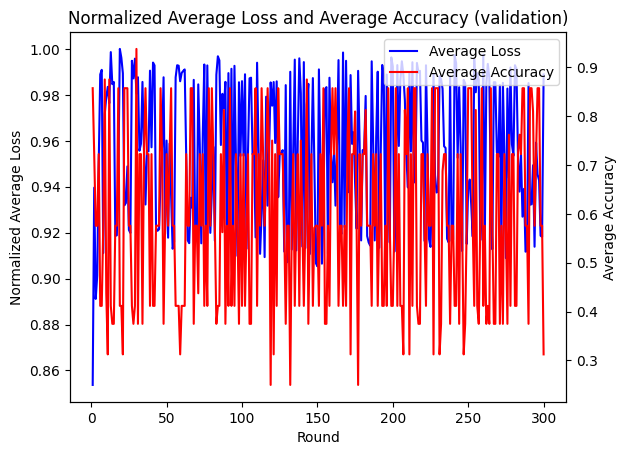

In [13]:
import matplotlib.pyplot as plt

# Create figure and axes
fig, ax1 = plt.subplots()


# Convert the list to a NumPy array
loss_val_round_np = np.array(loss_val_round)

# Plot the average loss on the left y-axis

ax1.plot(range(1, n_times + 1), loss_val_round_np/max(loss_val_round_np), label='Average Loss', color='blue')
# Explica que aquí no es la loss lo que pones en el plot, si no la versión normalizada
ax1.set_xlabel('Round')
ax1.set_ylabel('Normalized Average Loss')
ax1.tick_params(axis='y')

# Create a twin axes on the right side
ax2 = ax1.twinx()

ax2.plot(range(1, n_times + 1), acc_val_round, label='Average Accuracy', color='red')
ax2.set_ylabel('Average Accuracy')
ax2.tick_params(axis='y')

# Set the title
plt.title('Normalized Average Loss and Average Accuracy (validation)')

# Add legends
lines = [ax1.get_lines()[0], ax2.get_lines()[0]]
plt.legend(lines, [line.get_label() for line in lines])

# Display the plot
plt.show()

In [14]:
# The best equilibrium between acc_val_round and loss_val_round is found at the round 32
max_acc_round = np.argmax(acc_val_round) + 1
max_acc_round

30

In [15]:
optim_acc = acc_val_round[max_acc_round-1]
optim_loss = loss_val_round[max_acc_round-1]
print(" optim_acc:",optim_acc)
print(" optim_loss:",optim_loss)

 optim_acc: 0.9375
 optim_loss: 4.412394046783447


Repeat the process without using validation (i.e., now we do not leave data aside for validation since validation has already been done previously).

In [16]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=256, input_shape=(shape,), activation="relu", kernel_regularizer=regularizers.l1_l2(0.01)))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=128, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=32, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=1, activation="sigmoid"))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss="binary_crossentropy", 
                metrics=["accuracy", "AUC"])

In [17]:
#Set random seed
rn.seed(42)

# Get initial weights from created model before loop
initial_weights = model.get_weights()

# Maximum number of rounds n_times
n_times = max_acc_round

n = 0 # Variable to enter with the first client at the first round

# Initial parameters previous random client list generation
my_list = list(data_dict.keys())

# Initial weights previous rounds, it will be updated for each client on each round
saveModels = [model.get_weights()]*len(my_list)

# Create a tuple, to associate "my_list" and "saveModels" positions, even when shuffling
client_data_list = [(my_list[i], saveModels[i]) for i in range(len(my_list))]

# Rounds of the randomized gossip learning
for i in range(1,n_times+1):

    # Each round of the randomized gossip learning      
    for name in [client_data[0] for client_data in client_data_list]:
        if n == 0:
            # Train client:
            history = model.fit(data_dict[name]['X_train'],data_dict[name]['y_train'], epochs=14, batch_size=38, 
                          validation_split=0.15, verbose=0)
            # Saving the name for the next iteration
            name_prev = name
            n = 1
        else:
            # Saving previous weights
            weights_client_prev = model.get_weights()
            # Setting initial weights
            model.set_weights(initial_weights)
            # Train client:
            history = model.fit(data_dict[name]['X_train'],data_dict[name]['y_train'], epochs=14, batch_size=38, 
                          validation_split=0.15, verbose=0)
            # Obtain client weights:
            weights_client_new = model.get_weights()
            # Saving the name of the current iteration
            name_new = name
            # Calculating the lengths of the names of the previous and current iteration
            samples_len = [len(data_dict[name_prev]['X_train']),len(data_dict[name_new]['X_train'])]
            # Aggregate the weights obtained with each client using an aggregation function that performs a weighted average:
            avg_weights = ave_weights(samples_len,[weights_client_prev,weights_client_new]) # use of aggregation function
            model.set_weights(avg_weights)
            # Saving the name for the next iteration
            name_prev = name
    # Enter after first round
    last_client = client_data_list[-1][0]
    
    # Generates a randomized list with the condition of that
    # the last client from the previous client list 
    # not being equal to the first client of the current list.
    counter = 0
    # Do-while loop emulation:
    while True:
        rn.shuffle(client_data_list)
        counter += 1
        if client_data_list[0][0] != last_client:
            print(counter)
            break
model.save('model_initialTest_GL_random.h5')

1
1
1
1
2
1
2
2
1
1
1
1
1
3
1
1
1
1
1
1
1
1
2
3
2
2
2
1
1
1


In [19]:
for name in data_dict.keys():
    print(f'Client: {name}')
    score_test = model.evaluate(data_dict[name]['X_test'],data_dict[name]['y_test'], verbose = 0)
    print(f'Test loss: {score_test[0]}')
    print(f'Test accuracy: {score_test[1]}')
    print(f'Test AUC: {score_test[2]}\n')

Client: clev
Test loss: 4.522707939147949
Test accuracy: 0.5
Test AUC: 0.8407201766967773

Client: hung
Test loss: 4.6328840255737305
Test accuracy: 0.3243243098258972
Test AUC: 0.9012499451637268

Client: long
Test loss: 4.3762102127075195
Test accuracy: 0.7428571581840515
Test AUC: 0.9722222089767456

Client: stat
Test loss: 4.6151123046875
Test accuracy: 0.3684210479259491
Test AUC: 0.7083333134651184

Client: swit
Test loss: 4.34088659286499
Test accuracy: 0.8260869383811951
Test AUC: 0.8305920958518982

